In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

sns.set(rc={'figure.figsize':(15,8)})

path_to_catalog=r'C:\Users\kgrzebien\Desktop\python_tasks\kupony\zamawiajace\\'


In [2]:
def func_read_data(path, file):
    df=pd.read_csv(path+file+'.csv',
              encoding='Cp1250',
              sep="|")
    if 'IS_DELETED' in df.columns:
        df=df.loc[df['IS_DELETED']=='N']
    return df


def func_str_to_float(s):
    s=s.astype(str)
    s=s.apply(lambda x: x.replace(',','.'))
    s=s.astype(float)
    return s

def func_date(df, min_date, col_date):
    df[col_date]=pd.to_datetime(df[col_date], format='%y/%m/%d')
    
    df=df.loc[df[col_date]>=np.datetime64(min_date)].reset_index().drop('index', axis=1)
    df['year']=df[col_date].apply(lambda x: x.year)
    df['month']=df[col_date].apply(lambda x: x.month)
    df['day_of_year']=df[col_date].apply(lambda x: x.timetuple().tm_yday)
    df['week']=df[col_date].apply(lambda x: x.isocalendar()[1])
    df['week_day']=df[col_date].apply(lambda x: x.isocalendar()[2])
    df['year_month']=df['year'].astype(str)+'-'+df['month'].astype(str)+'-'+'01'
    df['year_month']=df['year_month'].apply(lambda x: x[:5]+'0'+x[5:] if len(x)==9 else x)
    df['year_month']=pd.to_datetime(df['year_month'], format='%Y-%m-%d')
    df['year_week']=df['year'].astype(str)+'--'+df['week'].astype(str)
    df['year_week']=df['year_week'].apply(lambda x: x[:6]+'0'+x[6:] if len(x)==7 else x)
    df['year_day']=df['year'].astype(str)+'--'+df['day_of_year'].astype(str)
    df['year_day']=df['year_day'].apply(lambda x: x[:6]+'0'+x[6:] if len(x)<9 else x)
    
    return df

def func_add_name_workers(df, name_of_file_with_workers):
    df_pracownicy=pd.read_excel(name_of_file_with_workers)
    df_pracownicy['NUMER']=df_pracownicy['NUMER']#.astype(str)
    df_pracownicy=df_pracownicy.rename(columns={'PELNANAZWA':'NAZWISKO'})
    df_pracownicy['NAZWISKO']=df_pracownicy['NAZWISKO'].apply(lambda x: x.split(' ')[0][0]+'. '+x.split(' ')[1] if len(x.split(' '))>1 else x)
    df=df.merge(df_pracownicy, how='left', left_on='KOD_OPER', right_on='NUMER')
    df=df.drop('NUMER', axis=1)
    return df

def func_typ_dokumentu(df):
    df['TYP_DOKUM']=df['TYP_DOKUM'].apply(lambda x: x if x=='M' else 'V')
    return df

In [83]:
def func_read_rcp(df_ewid_rcp,
                  df_zad_rcp):
    df_ewid_rcp=func_date_rcp(df_ewid_rcp)
    df_rcp=df_ewid_rcp[['ID_ZAD','DATA','ROZ_DNIA','ZAK_DNIA','GODZ_PL','DATA_ROZ','GODZ_ROZ','DATA_ZAK','GODZ_ZAK','KOD_OPER', 'date_start', 'date_finish','KOD_GR_RCP']].\
                merge(df_zad_rcp[['ID_ZAD','ZADANIE']].drop_duplicates(),
                      how='left', on='ID_ZAD')
            
    
    return df_rcp
    
def func_date_rcp(df):
    df=df.loc[df['GODZ_ROZ']!=' '].loc[df['GODZ_ZAK']!=' '].reset_index().drop('index', axis=1)
    df['date_start']=df['DATA']+' '+df['GODZ_ROZ']
    df['date_start']=pd.to_datetime(df['date_start'], format='%y/%m/%d %H:%M:%S')
    df['date_start']=df['date_start'].dt.floor('Min')
    df['date_finish']=df['DATA']+' '+df['GODZ_ZAK']
    df['date_finish']=pd.to_datetime(df['date_finish'], format='%y/%m/%d %H:%M:%S')
    df['date_finish']=df['date_finish'].dt.floor('Min')
    df['DATA']=pd.to_datetime(df['DATA'], format='%y/%m/%d')
    return df

df_grup_rcp=func_read_data('../../RCP_tables/',
                           'GRUP_RCP')
df_zad_rcp=func_read_data('../../RCP_tables/',
                           'ZAD_RCP')
df_ewid_rcp=func_read_data('../../RCP_tables/',
                           'EWID_RCP')

df_rcp=func_read_rcp(df_ewid_rcp, df_zad_rcp)
df_rcp=func_add_name_workers(df_rcp, '../../pracownicy.xlsx')

In [4]:
def func_minutes_in_work_day_rcp(df, tnaca1_numer):
    step=np.datetime64('2000-01-01 00:02:00')-np.datetime64('2000-01-01 00:01:00')
    
    df_with_minutes=pd.DataFrame(columns=['NAZWISKO', 'DATA', 'ile_minut_czynnosc', 'ile_minut_dzien', 'procent_wykorzystania', 'zadanie'])
    
    for day in (df.loc[df['NAZWISKO']==tnaca1_numer]['DATA'].unique()):
        arr_time_day=np.array([], dtype='datetime64')
        arr_time_activity=np.array([], dtype='int')
        arr_zadanie=[]
        arr_zadanie_group=[]
        try:
            for i in (df.loc[df['NAZWISKO']==tnaca1_numer].loc[df['DATA']==day].index):
                arr_tmp=np.arange(df.loc[i,'date_start'],
                                  df.loc[i,'date_finish'],
                                 step)
                arr_time_day=np.append(arr_time_day, arr_tmp)
                arr_time_activity=np.append(arr_time_activity, [len(arr_tmp)])
                arr_zadanie=np.append(arr_zadanie, [df.loc[i,'ZADANIE']])

            if len(arr_time_day)==0:
                display(day)
            ile_minut_maksymalnie=(arr_time_day.max()-arr_time_day.min())/np.timedelta64(1,'m')+1
            for time_activity, zadanie in zip(arr_time_activity, arr_zadanie ):
                df_with_minutes=df_with_minutes.append({'NAZWISKO':tnaca1_numer,
                                                        'DATA':day,
                                                        'ile_minut_czynnosc':time_activity,
                                                        'ile_minut_dzien':ile_minut_maksymalnie,
                                                       'procent_wykorzystania':time_activity/ile_minut_maksymalnie*100, 
                                                        'zadanie':zadanie},
                                                       ignore_index=True)
        except:
            pass
        
    
    return df_with_minutes

In [9]:
df_with_minutes_rcp=pd.DataFrame()
#flaga=0
for oper in tqdm(arr_kupony_obsluga_nazwiska):
    try:
        if oper == 0:
            continue

        df_with_minutes_tmp=func_minutes_in_work_day_rcp(df_rcp,
                                                             oper)
        df_with_minutes_rcp=df_with_minutes_rcp.append(df_with_minutes_tmp,
                                                          ignore_index=True)
    except:
        print(oper)
        continue

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [10:00<00:00, 75.09s/it]


In [113]:
df_with_minutes_rcp=func_date(df_with_minutes_rcp, '2020-01-01', 'DATA')

In [114]:
df_zamowienia=func_read_data('../zamawiajace/',
                             'zamowienia')
df_zamowienia=func_date(df_zamowienia, '2020-01-01', 'Z_DNIA')
df_zamowienia=func_add_name_workers(df_zamowienia, '../../pracownicy.xlsx')
df_zamowienia=func_typ_dokumentu(df_zamowienia)
df_zamowienia['WARTOSC_B_N13']=func_str_to_float(df_zamowienia['WARTOSC_B_N13'])
df_zamowienia['WARTOSC_B_ZAMOW1']=func_str_to_float(df_zamowienia['WARTOSC_B_ZAMOW1'])
df_zamowienia['FAKTURA_KD']=df_zamowienia['FAKTURA_KD'].apply(lambda x: 'nie_pusta' if x!='' else 'pusta')

In [115]:
# for i in ['B. DURAJ','E. KUBIENIEC','I. PAŁOSZ','A. BUŁAWA']:
#     display(i, df_rcp.loc[df_rcp['NAZWISKO']==i].groupby('ZADANIE').agg({'DATA':'nunique'}))
arr_kupony_obsluga_nazwiska=df_rcp.loc[df_rcp['ZADANIE']=='KUPONY-OBSŁUGA']['NAZWISKO'].unique()
#arr_kupony_obsluga_nazwiska=np.delete(arr_kupony_obsluga_nazwiska, np.where(arr_kupony_obsluga_nazwiska=='E. KUBIENIEC'))
arr_kupony_obsluga_nazwiska

array(['M. PSZCZÓŁKA', 'I. PAŁOSZ', 'J. SEMIK', 'B. DURAJ',
       'E. KUBIENIEC', 'I. DRABEK', 'R. KASPEREK', 'A. BUŁAWA'],
      dtype=object)

In [116]:
df_zamowienia.loc[df_zamowienia.loc[df_zamowienia['NAZWISKO'].isin(arr_kupony_obsluga_nazwiska)].index, 'czy_z_kuponow']='tak'
df_zamowienia['czy_z_kuponow']=df_zamowienia['czy_z_kuponow'].fillna('nie')

In [11]:
tmp=df_zamowienia.groupby(['czy_z_kuponow']).agg({'FAKTURA':'nunique'})
tmp['proc']=tmp['FAKTURA']/tmp['FAKTURA'].sum()*100
tmp

,FAKTURA,proc
czy_z_kuponow,,
nie,110219,67.487356
tak,53099,32.512644


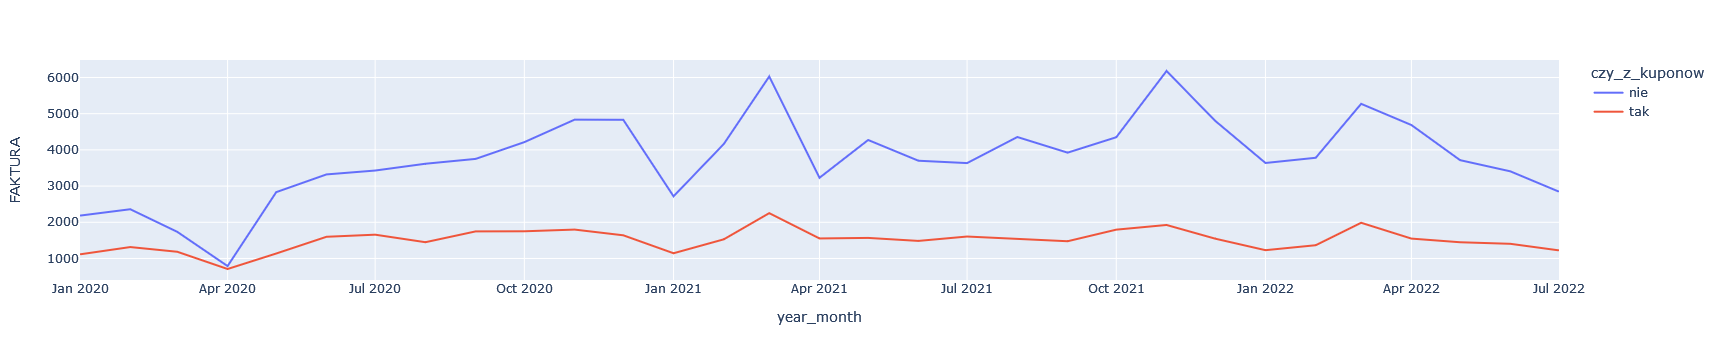

In [17]:
tmp=df_zamowienia.groupby(['czy_z_kuponow','year_month']).agg({'FAKTURA':'nunique',
                                                          'NAZWISKO':'nunique'}).reset_index()
px.line(tmp,
      x='year_month',
      y='FAKTURA',
      color='czy_z_kuponow')

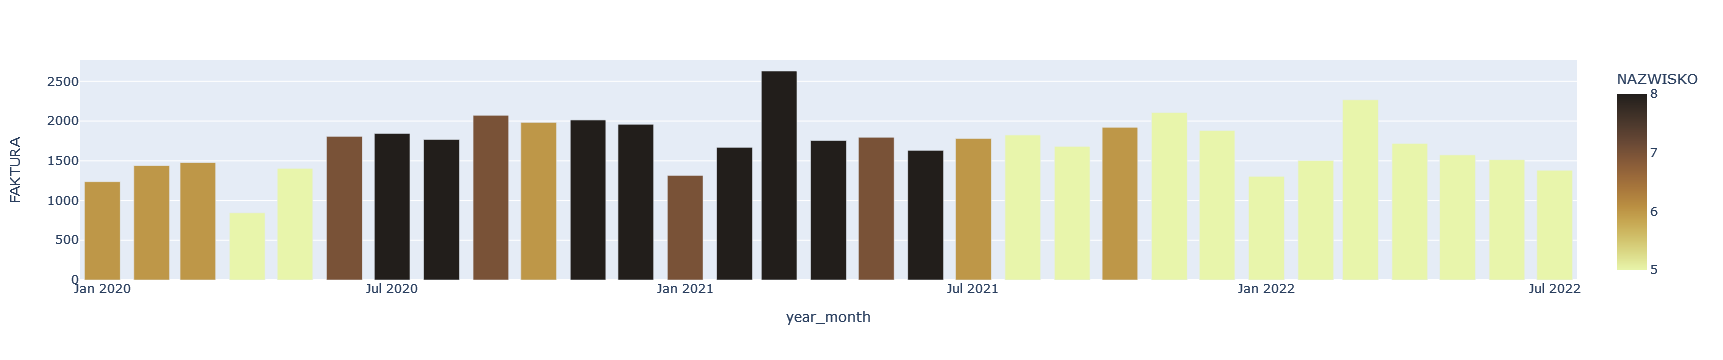

In [119]:
tmp=df_zamowienia.groupby(['czy_z_kuponow','year_month']).agg({'FAKTURA':'nunique',
                                                          'NAZWISKO':'nunique'}).reset_index()
fig=px.bar(tmp.loc[tmp['czy_z_kuponow']=='tak'],
      x='year_month',
      y='FAKTURA',
      color='NAZWISKO',
      color_continuous_scale='turbid')
fig.write_html(path_to_catalog+'faktury_per_mc_plus_ela.html')
fig.show()

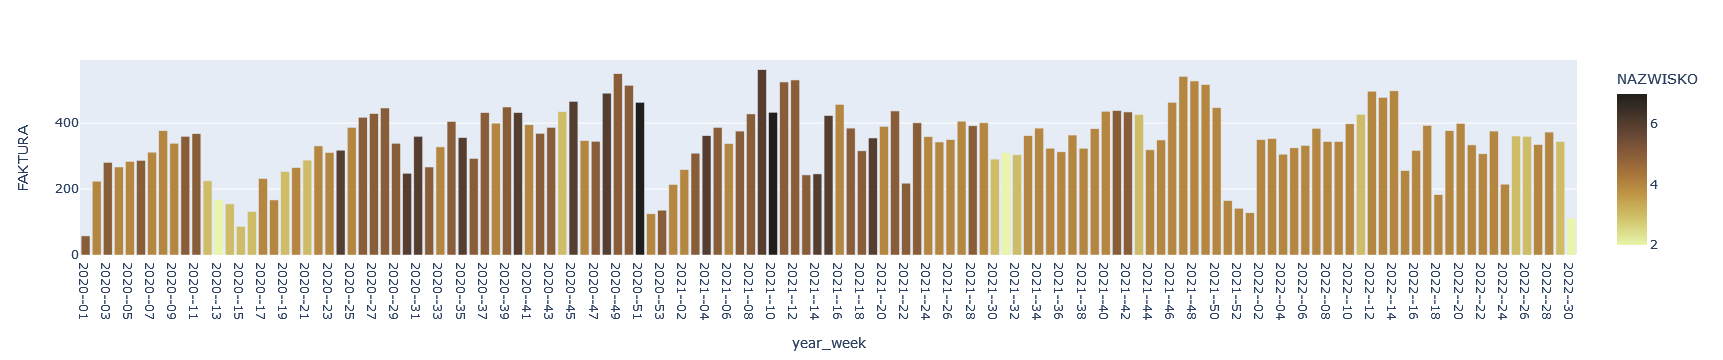

In [20]:
tmp=df_zamowienia.groupby(['czy_z_kuponow','year_week']).agg({'FAKTURA':'nunique',
                                                          'NAZWISKO':'nunique'}).reset_index()
px.bar(tmp.loc[tmp['czy_z_kuponow']=='tak'],
      x='year_week',
      y='FAKTURA',
      color='NAZWISKO',
      color_continuous_scale='turbid')

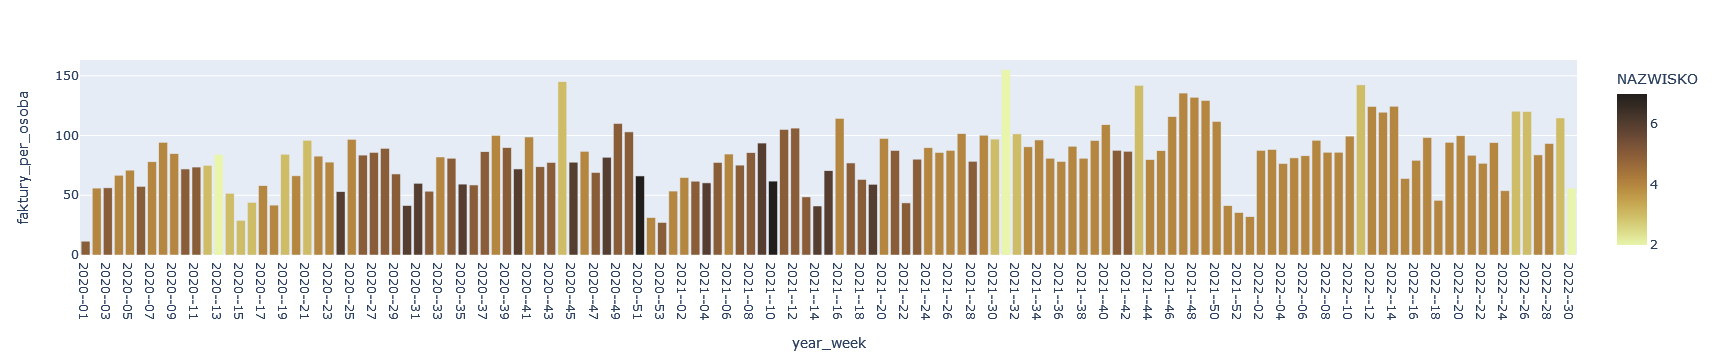

In [21]:
tmp=df_zamowienia.groupby(['czy_z_kuponow','year_week']).agg({'FAKTURA':'nunique',
                                                          'NAZWISKO':'nunique'}).reset_index()
tmp['faktury_per_osoba']=tmp['FAKTURA']/tmp['NAZWISKO']
px.bar(tmp.loc[tmp['czy_z_kuponow']=='tak'],
      x='year_week',
      y='faktury_per_osoba',
      color='NAZWISKO',
      color_continuous_scale='turbid')

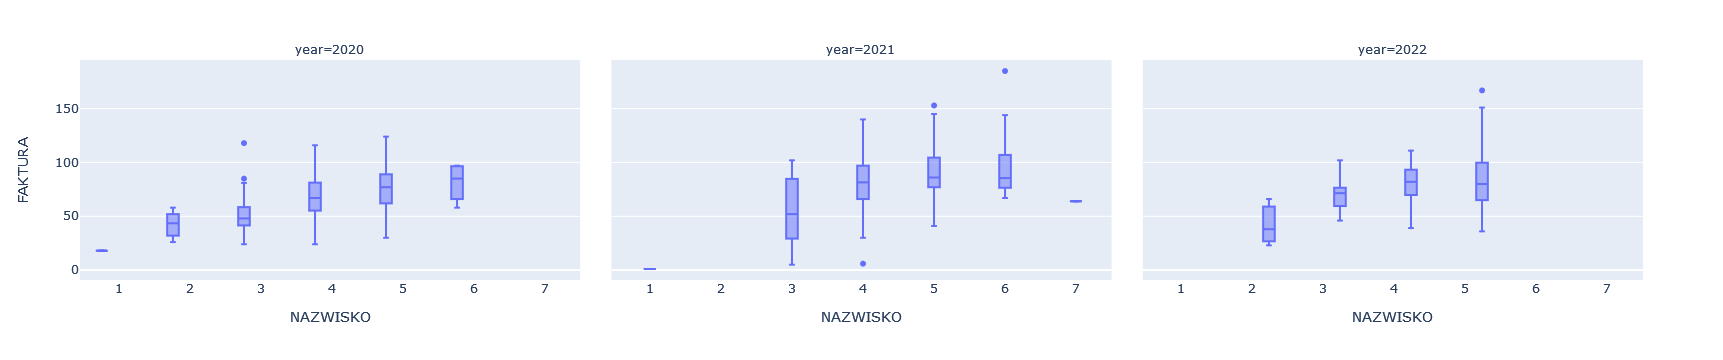

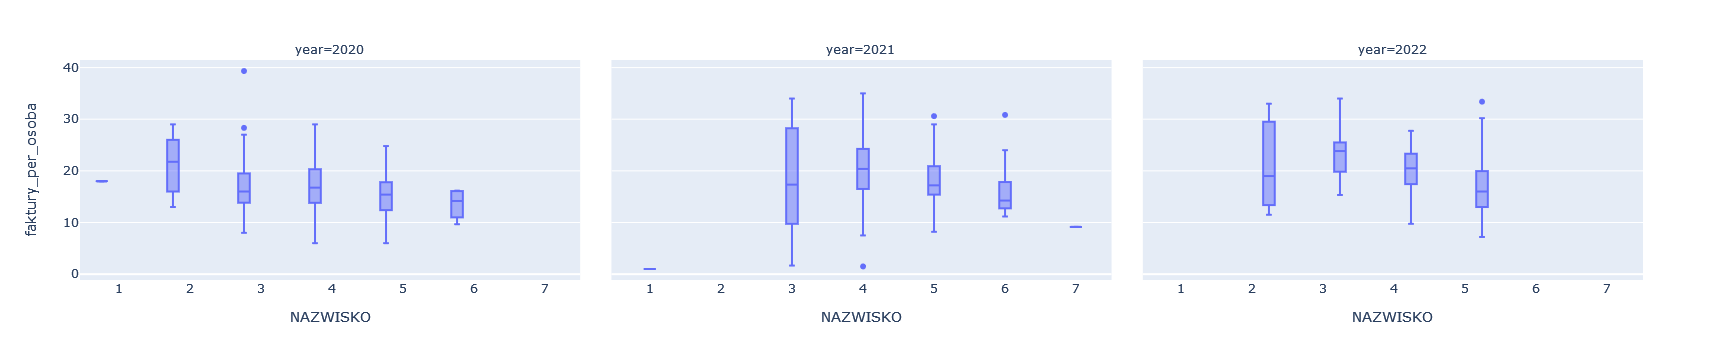

FAKTURA  faktury_per_osoba
year NAZWISKO                            
2020 1            18.0          18.000000
     2            43.5          21.750000
     3            48.0          16.000000
     4            67.0          16.750000
     5            77.0          15.400000
     6            85.0          14.166667
2021 1             1.0           1.000000
     3            52.0          17.333333
     4            81.5          20.375000
     5            86.0          17.200000
     6            85.5          14.250000
     7            64.0           9.142857
2022 2            38.0          19.000000
     3            71.5          23.833333
     4            82.0          20.500000
     5            80.0          16.000000

FAKTURA             faktury_per_osoba                      
year        2020  2021  2022              2020       2021       2022
NAZWISKO                                                            
1           18.0   1.0   NaN         18.000000   1.000000        NaN
2           43.5   NaN  38.0         21.750000        NaN  19.000000
3           48.0  52.0  71.5         16.000000  17.333333  23.833333
4           67.0  81.5  82.0         16.750000  20.375000  20.500000
5           77.0  86.0  80.0         15.400000  17.200000  16.000000
6           85.0  85.5   NaN         14.166667  14.250000        NaN
7            NaN  64.0   NaN               NaN   9.142857        NaN

In [121]:
tmp=df_zamowienia.groupby(['czy_z_kuponow','Z_DNIA','year','month']).agg({'FAKTURA':'nunique',
                                                          'NAZWISKO':'nunique'}).reset_index()
tmp['faktury_per_osoba']=tmp['FAKTURA']/tmp['NAZWISKO']

fig=px.box(tmp.loc[tmp['czy_z_kuponow']=='tak'].loc[tmp['month']<=6],
      x='NAZWISKO',
      y='FAKTURA',
          facet_col='year')
fig.write_html(path_to_catalog+'faktury_box_plus_ela.html')
fig.show()

fig=px.box(tmp.loc[tmp['czy_z_kuponow']=='tak'].loc[tmp['month']<=6],
      x='NAZWISKO',
      y='faktury_per_osoba',
          facet_col='year')
fig.write_html(path_to_catalog+'faktury_per_osoba_box_plus_ela.html')
fig.show()

display(tmp.loc[tmp['czy_z_kuponow']=='tak'].loc[tmp['month']<=6].groupby(['year','NAZWISKO']).agg({'FAKTURA':'median',
                                                   'faktury_per_osoba':'median'}).head(50))

display(tmp.loc[tmp['czy_z_kuponow']=='tak'].loc[tmp['month']<=6].groupby(['year','NAZWISKO']).agg({'FAKTURA':'median',
                                                                                               'faktury_per_osoba':'median'}).reset_index().\
        pivot(columns='year', index='NAZWISKO',values=['FAKTURA','faktury_per_osoba']))
tmp.loc[tmp['czy_z_kuponow']=='tak'].loc[tmp['month']<=6].groupby(['year','NAZWISKO']).agg({'FAKTURA':'median',
                                                                                               'faktury_per_osoba':'median'}).reset_index().\
        pivot(columns='year', index='NAZWISKO',values=['FAKTURA','faktury_per_osoba']).to_excel(path_to_catalog+'pivot_box_median_plus_ela.xlsx')

In [23]:
tmp=df_zamowienia.groupby(['czy_z_kuponow','Z_DNIA']).agg({'FAKTURA':'nunique',
                                                          'NAZWISKO':'nunique'}).reset_index()
tmp['faktury_per_osoba']=tmp['FAKTURA']/tmp['NAZWISKO']

In [70]:
def func_raport_pivot(df, year1, year2, month, df_with_minutes_rcp):
    df1=df.loc[df['year']==year1].loc[df['month'].isin(month)]
    df2=df.loc[df['year']==year2].loc[df['month'].isin(month)]
    df_with_minutes_rcp1=df_with_minutes_rcp.loc[df_with_minutes_rcp['year']==year1].loc[df_with_minutes_rcp['month'].isin(month)]
    df_with_minutes_rcp2=df_with_minutes_rcp.loc[df_with_minutes_rcp['year']==year2].loc[df_with_minutes_rcp['month'].isin(month)]
    
    # display(pd.pivot_table(df1,
    #               index='NAZWISKO',
    #               columns=col,
    #               aggfunc=np.sum()))
    df_tmp1=df1.groupby(['NAZWISKO','month']).agg({'FAKTURA':'nunique'})
    df_tmp1=df_tmp1.rename(columns={'FAKTURA':'FAKTURA_'+str(year1)})
    df_tmp2=df2.groupby(['NAZWISKO','month']).agg({'FAKTURA':'nunique'})
    df_tmp2=df_tmp2.rename(columns={'FAKTURA':'FAKTURA_'+str(year2)})
    df_tmp1_rcp=df_with_minutes_rcp1.loc[df_with_minutes_rcp1['zadanie']=='KUPONY-OBSŁUGA'].groupby(['NAZWISKO','month']).agg({'ile_minut_czynnosc':'sum'})
    df_tmp1_rcp=df_tmp1_rcp.rename(columns={'ile_minut_czynnosc':'ile_minut_czynnosc_'+str(year1)})
    df_tmp2_rcp=df_with_minutes_rcp2.loc[df_with_minutes_rcp2['zadanie']=='KUPONY-OBSŁUGA'].groupby(['NAZWISKO','month']).agg({'ile_minut_czynnosc':'sum'})
    df_tmp2_rcp=df_tmp2_rcp.rename(columns={'ile_minut_czynnosc':'ile_minut_czynnosc_'+str(year2)})
    
    df_tmp=df_tmp1.merge(df_tmp2,
                         how='outer',
                         left_index=True, right_index=True).\
                   merge(df_tmp1_rcp,
                                 how='left',
                                 left_index=True, right_index=True).\
                   merge(df_tmp2_rcp,
                                 how='left',
                                 left_index=True, right_index=True). reset_index()
    for i in [year1, year2]:
        df_tmp['ile_minut_czynnosc_'+str(i)]=df_tmp['ile_minut_czynnosc_'+str(i)].apply(lambda x: round(x/60, 1))
        df_tmp=df_tmp.rename(columns={'ile_minut_czynnosc_'+str(i) : 'ile_godzin_czynnosc_'+str(i)})
        df_tmp['FAKTURA_na_godzine_'+str(i)]=round(df_tmp['FAKTURA_'+str(i)]/df_tmp['ile_godzin_czynnosc_'+str(i)], 2)
        
    return df_tmp

In [73]:
raport_pivot=func_raport_pivot(df_zamowienia.loc[df_zamowienia['czy_z_kuponow']=='tak'], 2021, 2022, [1,2,3,4,5,6], df_with_minutes_rcp)
raport_pivot.to_excel(path_to_catalog+'raport_pivot_zamowienia_telefony.xlsx')
display(raport_pivot)

,NAZWISKO,month,FAKTURA_2021,FAKTURA_2022,ile_godzin_czynnosc_2021,ile_godzin_czynnosc_2022,FAKTURA_na_godzine_2021,FAKTURA_na_godzine_2022
0,A. BUŁAWA,1,1.0,325.0,NaN,156.7,NaN,2.07
1,A. BUŁAWA,2,1.0,411.0,NaN,156.9,NaN,2.62
2,A. BUŁAWA,3,5.0,472.0,NaN,180.7,NaN,2.61
3,A. BUŁAWA,4,2.0,288.0,NaN,132.4,NaN,2.18
4,A. BUŁAWA,5,NaN,349.0,NaN,146.0,NaN,2.39
5,A. BUŁAWA,6,412.0,441.0,151.9,156.5,2.71,2.82
6,B. DURAJ,1,360.0,382.0,161.9,157.3,2.22,2.43
7,B. DURAJ,2,534.0,318.0,145.0,132.5,3.68,2.40
8,B. DURAJ,3,769.0,516.0,215.3,148.5,3.57,3.47
9,B. DURAJ,4,509.0,595.0,151.5,154.8,3.36,3.84


In [37]:
df_zamowienia.groupby(['year_month','NAZWISKO','czy_z_kuponow']).agg({'FAKTURA':'nunique'}).reset_index().to_excel(path_to_catalog+'zestawienie_faktur_po_mc.xlsx')

In [106]:
arr_lista_zadan=df_rcp.loc[df_rcp['NAZWISKO']=='G. HOWANIEC']['ZADANIE'].unique()
for i in ['PRZERWA','URLOP','CHOROBOWE','REMANENT','URLOP OKOLICZNOŚCIOWY', 'MAGAZYN -POMOC']:
    arr_lista_zadan=np.delete(arr_lista_zadan, np.where(arr_lista_zadan==i))
    
display(arr_lista_zadan)    
display(df_rcp.loc[df_rcp['NAZWISKO']=='G. HOWANIEC'][['ZADANIE','KOD_GR_RCP']].drop_duplicates())

array(['RELOKACJA', 'KUPONY PAKOWANIE AUTOMAT', 'KUPONY PAKOWANIE',
       'LISTOWANIE AUTOMAT'], dtype=object)

,ZADANIE,KOD_GR_RCP
19,PRZERWA,KUP
72,RELOKACJA,KUP
2792,KUPONY PAKOWANIE AUTOMAT,KUP
37900,KUPONY PAKOWANIE,KUP
54883,URLOP,KUP
96254,CHOROBOWE,KUP
115664,MAGAZYN -POMOC,KUP
193015,LISTOWANIE AUTOMAT,KUP
208335,REMANENT,KUP
525894,URLOP OKOLICZNOŚCIOWY,KUP


In [91]:
df_rcp.loc[df_rcp['ZADANIE'].isin(arr_lista_zadan)].loc[df_rcp['KOD_GR_RCP']=='KUP']

,ID_ZAD,DATA,ROZ_DNIA,ZAK_DNIA,GODZ_PL,DATA_ROZ,GODZ_ROZ,DATA_ZAK,GODZ_ZAK,KOD_OPER,date_start,date_finish,KOD_GR_RCP,ZADANIE,NAZWISKO
72,ZP0000000377,2021-02-03,,,,21/02/03,10:18:25,21/02/03,13:30:19,1427,2021-02-03 10:18:00,2021-02-03 13:30:00,KUP,RELOKACJA,G. HOWANIEC
73,ZP0000006461,2021-02-03,,,,21/02/03,10:18:34,21/02/03,13:30:59,196,2021-02-03 10:18:00,2021-02-03 13:30:00,KUP,LISTOWANIE AUTOMAT,M. MIESZCZAK
74,ZP0000000377,2021-02-03,,,,21/02/03,10:18:43,21/02/03,13:30:38,1711,2021-02-03 10:18:00,2021-02-03 13:30:00,KUP,RELOKACJA,K. TOMIAK
78,ZP0000000377,2021-02-03,,,,21/02/03,10:18:50,21/02/03,13:30:39,1954,2021-02-03 10:18:00,2021-02-03 13:30:00,KUP,RELOKACJA,M. PROCHOWNIK
82,ZP0000000377,2021-02-03,,,,21/02/03,10:19:02,21/02/03,13:30:20,1888,2021-02-03 10:19:00,2021-02-03 13:30:00,KUP,RELOKACJA,R. DRÓŻDŻ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574500,ZP0000000937,2022-06-03,,,,22/06/03,15:56:38,22/06/03,17:08:00,1931,2022-06-03 15:56:00,2022-06-03 17:08:00,KUP,MAGAZYN -POMOC,E. PALA
574501,ZP0000000937,2022-06-03,,,,22/06/03,15:56:48,22/06/03,17:07:49,322,2022-06-03 15:56:00,2022-06-03 17:07:00,KUP,MAGAZYN -POMOC,A. OKRZESIK
574594,ZP0000000377,2022-06-13,,,,22/06/13,05:21:38,22/06/13,13:30:09,1145,2022-06-13 05:21:00,2022-06-13 13:30:00,KUP,RELOKACJA,P. MIKOCIAK
574840,ZP0000006461,2022-06-21,,,,22/06/21,10:20:31,22/06/21,13:30:20,196,2022-06-21 10:20:00,2022-06-21 13:30:00,KUP,LISTOWANIE AUTOMAT,M. MIESZCZAK


In [92]:
df_rcp.loc[df_rcp['ZADANIE'].isin(arr_lista_zadan)].loc[df_rcp['KOD_GR_RCP']=='KUP']['NAZWISKO'].unique()

array(['G. HOWANIEC', 'M. MIESZCZAK', 'K. TOMIAK', 'M. PROCHOWNIK',
       'R. DRÓŻDŻ', 'P. MIKOCIAK', 'K. OŻGA', 'K. GRZYBOWSKI', 'M. TKACZ',
       'K. WOSZCZEK', 'P. WOJTAS', 'M. ŻUKOWSKI', 'D. LEŚNIAK',
       'M. ZEMAN', 'P. MAŚLANKA', 'P. KABAT', 'S. KURAS', 'A. BUŁAWA',
       'I. DRABEK', 'B. DURAJ', 'D. CIEŚLAWSKI', 'M. GÓRNY',
       'E. MAJCHEREK', 'J. CYGOŃ', 'A. TOMASZEK', 'E. MIKUSZEK-CZUL',
       'Z. LEJAWA', 'S. KAPAŁA', 'S. WISŁA', 'A. SZYMAŃSKA', 'P. PUCHACZ',
       'P. WIDUCH', 'A. KASTELIK', 'K. RYPIEŃ', 'A. KRZAK', 'S. NISZWIC',
       'E. PALA', 'A. OKRZESIK', 'G. ŁUKAŃKO', 'M. PTAK'], dtype=object)

In [94]:
df_rcp.loc[df_rcp['ZADANIE'].isin(arr_lista_zadan)].loc[df_rcp['KOD_GR_RCP']=='KUP'].loc[df_rcp['NAZWISKO']=='S. NISZWIC']

,ID_ZAD,DATA,ROZ_DNIA,ZAK_DNIA,GODZ_PL,DATA_ROZ,GODZ_ROZ,DATA_ZAK,GODZ_ZAK,KOD_OPER,date_start,date_finish,KOD_GR_RCP,ZADANIE,NAZWISKO
500961,ZP0000000937,2022-03-02,,,,22/03/02,10:59:38,22/03/02,13:30:08,956,2022-03-02 10:59:00,2022-03-02 13:30:00,KUP,MAGAZYN -POMOC,S. NISZWIC


In [103]:
_=['D. CIEŚLAWSKI', 'K. GRZYBOWSKI', 'G. HOWANIEC', 'A. KASTELIK',
       'P. MIKOCIAK', 'M. MIESZCZAK', 'K. OŻGA', 'M. PROCHOWNIK',
       'M. PTAK', 'P. PUCHACZ', 'M. ŻUKOWSKI']

In [111]:
df_rcp.loc[df_rcp['ZADANIE'].isin(['RELOKACJA'])].loc[df_rcp['KOD_GR_RCP']=='KUP'].loc[~df_rcp['NAZWISKO'].isin(_)].groupby(['NAZWISKO','ZADANIE']).agg({'DATA':'nunique'}).reset_index()['NAZWISKO'].unique()

array(['D. LEŚNIAK', 'J. CYGOŃ', 'K. TOMIAK', 'K. WOSZCZEK', 'M. TKACZ',
       'P. KABAT', 'P. WOJTAS', 'R. DRÓŻDŻ', 'S. KURAS'], dtype=object)

In [105]:
df_rcp.loc[df_rcp['ZADANIE'].isin(arr_lista_zadan)].loc[df_rcp['KOD_GR_RCP']=='KUP'].loc[df_rcp['NAZWISKO'].isin(_)].groupby(['NAZWISKO','ZADANIE']).agg({'DATA':'nunique'})

DATA
NAZWISKO      ZADANIE                       
A. KASTELIK   MAGAZYN -POMOC               1
              RELOKACJA                   84
D. CIEŚLAWSKI MAGAZYN -POMOC               1
              RELOKACJA                  165
G. HOWANIEC   KUPONY PAKOWANIE             1
              KUPONY PAKOWANIE AUTOMAT    50
              LISTOWANIE AUTOMAT           2
              MAGAZYN -POMOC               7
              RELOKACJA                  566
K. GRZYBOWSKI MAGAZYN -POMOC              11
              RELOKACJA                  467
K. OŻGA       LISTOWANIE AUTOMAT          26
              MAGAZYN -POMOC               4
              RELOKACJA                  497
M. MIESZCZAK  KUPONY PAKOWANIE AUTOMAT     1
              LISTOWANIE AUTOMAT         443
              MAGAZYN -POMOC               2
              RELOKACJA                  496
M. PROCHOWNIK KUPONY PAKOWANIE AUTOMAT     1
              MAGAZYN -POMOC               4
              RELOKACJA                  371
M. PTAK       RELOKACJA                   52
M. ŻUKOWSKI   KUPONY PAKOWANIE AUTOMAT     1
              RELOKACJA                  441
P. MIKOCIAK   KUPONY PAKOWANIE             2
              KUPONY PAKOWANIE AUTOMAT    36
              LISTOWANIE AUTOMAT         346
              MAGAZYN -POMOC               5
              RELOKACJA                  503
P. PUCHACZ    RELOKACJA                   83

In [124]:
df_zamowienia.loc[df_zamowienia['KOD'].str.contains('XXX')]['KOD'].unique()

array(['90XXXX', 'QMXXXX', 'QKXXXX', 'QSXXXX', 'O6XXXX', 'QTXXXX',
       'QLXXXX', 'QNXXXX', '52XXXX', 'QJXXXX', 'AOXXXX', 'QOXXXX',
       'Q4XXXX', 'X3XXXX', 'QPXXXX', 'O8XXXX', 'SCXXXX', '62XXXX',
       '22XXXX', 'QIXXXX', 'QUXXXX', 'QQXXXX', 'DYXXXX', 'QGXXXX',
       '36XXXX', 'QWXXXX', '29XXXX', 'QRXXXX', 'AJXXXX', '56XXXX',
       'QXXXXX', '37XXXX'], dtype=object)

In [125]:
df_zamowienia.loc[df_zamowienia['KOD'].str.contains('29XXXX')]

,FAKTURA,Z_DNIA,KOD,KOD_OPER,FAKTURA_KD,OPIS,RODZAJ,TYP_DOKUM,WARTOSC_B_N13,WARTOSC_B_ZAMOW1,year,month,day_of_year,week,week_day,year_month,year_week,year_day,NAZWISKO,czy_z_kuponow
35579,ZO6000246247,2020-10-23,29XXXX,409,nie_pusta,0,RZ,M,582.84,582.84,2020,10,297,43,5,2020-10-01,2020--43,2020--297,E. JANOTA,nie
43614,ZO6000238247,2020-09-30,29XXXX,432,nie_pusta,0,RZ,M,281.42,281.42,2020,9,274,40,3,2020-09-01,2020--40,2020--274,I. PAŁOSZ,tak
48673,ZO6000278792,2021-01-20,29XXXX,199,nie_pusta,0,RZ,M,647.82,647.82,2021,1,20,3,3,2021-01-01,2021--03,2021--020,M. PIĄTEK,nie
53267,ZO6000277498,2021-01-15,29XXXX,199,nie_pusta,0,RZ,M,99.63,99.63,2021,1,15,2,5,2021-01-01,2021--02,2021--015,M. PIĄTEK,nie
56018,ZO6000266103,2020-12-09,29XXXX,199,nie_pusta,0,RZ,M,420.11,420.11,2020,12,344,50,3,2020-12-01,2020--50,2020--344,M. PIĄTEK,nie
56019,ZO6000266419,2020-12-09,29XXXX,199,nie_pusta,0,RZ,M,165.50,165.50,2020,12,344,50,3,2020-12-01,2020--50,2020--344,M. PIĄTEK,nie
59004,ZO6000278134,2021-01-18,29XXXX,199,nie_pusta,0,RZ,M,77.22,77.22,2021,1,18,3,1,2021-01-01,2021--03,2021--018,M. PIĄTEK,nie
59763,ZO6000279504,2021-01-22,29XXXX,199,nie_pusta,0,RZ,M,232.47,232.47,2021,1,22,3,5,2021-01-01,2021--03,2021--022,M. PIĄTEK,nie
60532,ZO6000278922,2021-01-20,29XXXX,461,nie_pusta,0,RZ,M,1200.23,1200.23,2021,1,20,3,3,2021-01-01,2021--03,2021--020,J. SEMIK,tak
71098,ZO6000307609,2021-04-07,29XXXX,199,nie_pusta,0,RZ,M,684.05,684.05,2021,4,97,14,3,2021-04-01,2021--14,2021--097,M. PIĄTEK,nie
